In [12]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from datetime import datetime, timedelta
import requests
import json
import warnings
warnings.filterwarnings('ignore')

In [15]:
import tensorflow as tf
from tensorflow.keras.models import Sequential, load_model
from tensorflow.keras.layers import LSTM, Dense, Dropout, BatchNormalization
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.callbacks import EarlyStopping, ModelCheckpoint, ReduceLROnPlateau
from sklearn.preprocessing import MinMaxScaler, StandardScaler
from sklearn.metrics import mean_squared_error, mean_absolute_error, accuracy_score, classification_report
from sklearn.model_selection import train_test_split

In [16]:
np.random.seed(42)
tf.random.set_seed(42)

class WeatherDataCollector:
    """Handles data collection from multiple weather APIs and datasets"""

    def __init__(self):
        self.api_keys = {
            'openweather': 'YOUR_OPENWEATHER_API_KEY',  # Get free key from openweathermap.org
            'weatherbit': 'YOUR_WEATHERBIT_API_KEY'     # Get free key from weatherbit.io
        }

    def generate_synthetic_data(self, days=1000):
        """Generate synthetic weather data for demonstration"""
        print("🌦️  Generating synthetic weather data for demonstration...")

        # Create date range
        end_date = datetime.now()
        start_date = end_date - timedelta(days=days)
        dates = pd.date_range(start=start_date, end=end_date, freq='D')

        # Generate realistic weather patterns
        np.random.seed(42)
        n_days = len(dates)

        # Base seasonal patterns
        day_of_year = dates.dayofyear
        seasonal_temp = 20 + 15 * np.sin(2 * np.pi * day_of_year / 365.25)
        seasonal_humidity = 60 + 20 * np.sin(2 * np.pi * (day_of_year + 90) / 365.25)

        # Generate correlated weather features
        temperature = seasonal_temp + np.random.normal(0, 5, n_days)
        humidity = seasonal_humidity + np.random.normal(0, 10, n_days)
        pressure = 1013 + np.random.normal(0, 15, n_days)
        wind_speed = np.abs(np.random.normal(10, 5, n_days))
        cloud_cover = np.random.uniform(0, 100, n_days)

        # Generate rainfall with realistic patterns
        # Higher probability of rain with high humidity, low pressure, high cloud cover
        rain_probability = (
            0.3 * (humidity > 75) +
            0.2 * (pressure < 1000) +
            0.2 * (cloud_cover > 70) +
            0.1 * (wind_speed > 15) +
            0.1 * np.random.random(n_days)
        )

        rainfall = np.zeros(n_days)
        for i in range(n_days):
            if np.random.random() < rain_probability[i]:
                rainfall[i] = np.random.exponential(5)  # Exponential distribution for rain amounts

        # Create DataFrame
        data = pd.DataFrame({
            'date': dates,
            'temperature': np.round(temperature, 2),
            'humidity': np.clip(np.round(humidity, 2), 0, 100),
            'pressure': np.round(pressure, 2),
            'wind_speed': np.round(wind_speed, 2),
            'cloud_cover': np.clip(np.round(cloud_cover, 2), 0, 100),
            'rainfall': np.round(rainfall, 2)
        })

        print(f"✅ Generated {len(data)} days of synthetic weather data")
        return data

    def collect_real_data(self, city="London", days=30):
        """Collect real weather data (requires API keys)"""
        try:
            # This is a placeholder - implement actual API calls here
            print(f"🌍 Collecting real weather data for {city}...")
            print("⚠️  Note: Replace with actual API implementation")
            return self.generate_synthetic_data(days)
        except Exception as e:
            print(f"❌ Error collecting real data: {e}")
            print("🔄 Falling back to synthetic data...")
            return self.generate_synthetic_data(days)


In [17]:
class WeatherPreprocessor:
    """Handles all data preprocessing and feature engineering"""

    def __init__(self):
        self.scalers = {}
        self.feature_columns = []

    def engineer_features(self, data):
        """Create advanced features from raw weather data"""
        print("🔧 Engineering features...")

        df = data.copy()

        # Time-based features
        df['day_of_year'] = df['date'].dt.dayofyear
        df['month'] = df['date'].dt.month
        df['day_of_week'] = df['date'].dt.dayofweek
        df['season'] = df['month'].map({
            12: 0, 1: 0, 2: 0,  # Winter
            3: 1, 4: 1, 5: 1,   # Spring
            6: 2, 7: 2, 8: 2,   # Summer
            9: 3, 10: 3, 11: 3  # Autumn
        })

        # Cyclical encoding for time features
        df['day_sin'] = np.sin(2 * np.pi * df['day_of_year'] / 365.25)
        df['day_cos'] = np.cos(2 * np.pi * df['day_of_year'] / 365.25)
        df['month_sin'] = np.sin(2 * np.pi * df['month'] / 12)
        df['month_cos'] = np.cos(2 * np.pi * df['month'] / 12)

        # Weather interaction features
        df['temp_humidity'] = df['temperature'] * df['humidity'] / 100
        df['pressure_diff'] = df['pressure'] - df['pressure'].rolling(7).mean()
        df['humidity_pressure'] = df['humidity'] * (1013 - df['pressure']) / 100
        df['wind_cloud'] = df['wind_speed'] * df['cloud_cover'] / 100

        # Rolling statistics (weather trends)
        for window in [3, 7, 14]:
            df[f'temp_roll_{window}'] = df['temperature'].rolling(window).mean()
            df[f'humidity_roll_{window}'] = df['humidity'].rolling(window).mean()
            df[f'pressure_roll_{window}'] = df['pressure'].rolling(window).mean()
            df[f'rainfall_roll_{window}'] = df['rainfall'].rolling(window).sum()

        # Lag features (previous day weather)
        for lag in [1, 2, 3]:
            df[f'temp_lag_{lag}'] = df['temperature'].shift(lag)
            df[f'humidity_lag_{lag}'] = df['humidity'].shift(lag)
            df[f'pressure_lag_{lag}'] = df['pressure'].shift(lag)
            df[f'rainfall_lag_{lag}'] = df['rainfall'].shift(lag)

        # Rain indicator
        df['rain_binary'] = (df['rainfall'] > 0).astype(int)
        df['heavy_rain'] = (df['rainfall'] > 10).astype(int)

        # Drop rows with NaN values created by rolling and lag features
        df = df.dropna()

        print(f"✅ Created {df.shape[1]} features from {data.shape[1]} original columns")
        return df

    def prepare_sequences(self, data, sequence_length=30, target_column='rainfall'):
        """Create sequences for LSTM training"""
        print(f"📊 Preparing sequences with length {sequence_length}...")

        # Select feature columns (exclude date and target)
        feature_cols = [col for col in data.columns if col not in ['date', target_column]]
        self.feature_columns = feature_cols

        # Scale features
        scaler_X = MinMaxScaler()
        scaler_y = MinMaxScaler()

        X_scaled = scaler_X.fit_transform(data[feature_cols])
        y_scaled = scaler_y.fit_transform(data[target_column].values.reshape(-1, 1))

        self.scalers['features'] = scaler_X
        self.scalers['target'] = scaler_y

        # Create sequences
        X_sequences, y_sequences = [], []

        for i in range(sequence_length, len(X_scaled)):
            X_sequences.append(X_scaled[i-sequence_length:i])
            y_sequences.append(y_scaled[i])

        X_sequences = np.array(X_sequences)
        y_sequences = np.array(y_sequences)

        print(f"✅ Created {len(X_sequences)} sequences")
        print(f"📏 Sequence shape: {X_sequences.shape}")

        return X_sequences, y_sequences, data.iloc[sequence_length:]


In [18]:
class RainfallLSTM:
    """Advanced LSTM model for rainfall prediction"""

    def __init__(self, input_shape, model_type='regression'):
        self.input_shape = input_shape
        self.model_type = model_type
        self.model = None
        self.history = None

    def build_model(self, lstm_units=[128, 64, 32], dropout_rate=0.3, learning_rate=0.001):
        """Build advanced LSTM architecture"""
        print("🏗️  Building LSTM model...")

        model = Sequential()

        # First LSTM layer
        model.add(LSTM(lstm_units[0],
                      return_sequences=True,
                      input_shape=self.input_shape))
        model.add(BatchNormalization())
        model.add(Dropout(dropout_rate))

        # Second LSTM layer
        model.add(LSTM(lstm_units[1],
                      return_sequences=True))
        model.add(BatchNormalization())
        model.add(Dropout(dropout_rate))

        # Third LSTM layer
        model.add(LSTM(lstm_units[2],
                      return_sequences=False))
        model.add(BatchNormalization())
        model.add(Dropout(dropout_rate))

        # Dense layers
        model.add(Dense(64, activation='relu'))
        model.add(Dropout(dropout_rate))
        model.add(Dense(32, activation='relu'))
        model.add(Dropout(dropout_rate))

        # Output layer
        if self.model_type == 'regression':
            model.add(Dense(1, activation='linear'))
            model.compile(optimizer=Adam(learning_rate=learning_rate),
                         loss='mse',
                         metrics=['mae', 'mse'])
        else:  # classification
            model.add(Dense(1, activation='sigmoid'))
            model.compile(optimizer=Adam(learning_rate=learning_rate),
                         loss='binary_crossentropy',
                         metrics=['accuracy'])

        self.model = model
        print("✅ Model built successfully")
        print(f"📊 Model parameters: {model.count_params():,}")
        return model

    def train(self, X_train, y_train, X_val, y_val, epochs=100, batch_size=32):
        """Train the model with advanced callbacks"""
        print("🚀 Starting training...")

        callbacks = [
            EarlyStopping(patience=20, restore_best_weights=True, monitor='val_loss'),
            ReduceLROnPlateau(factor=0.5, patience=10, min_lr=1e-7, monitor='val_loss'),
            ModelCheckpoint('best_rainfall_model.h5', save_best_only=True, monitor='val_loss')
        ]

        self.history = self.model.fit(
            X_train, y_train,
            validation_data=(X_val, y_val),
            epochs=epochs,
            batch_size=batch_size,
            callbacks=callbacks,
            verbose=1
        )

        print("✅ Training completed!")
        return self.history

    def predict(self, X_test, scaler_y):
        """Make predictions and inverse transform"""
        predictions_scaled = self.model.predict(X_test)
        predictions = scaler_y.inverse_transform(predictions_scaled)
        return predictions.flatten()


In [19]:
class ModelEvaluator:
    """Comprehensive model evaluation and visualization"""

    def __init__(self):
        self.metrics = {}

    def evaluate_regression(self, y_true, y_pred, title="Rainfall Prediction"):
        """Evaluate regression performance"""
        print(f"📊 Evaluating {title}...")

        # Calculate metrics
        rmse = np.sqrt(mean_squared_error(y_true, y_pred))
        mae = mean_absolute_error(y_true, y_pred)

        # Classification metrics (rain/no-rain)
        y_true_binary = (y_true > 0).astype(int)
        y_pred_binary = (y_pred > 0).astype(int)
        accuracy = accuracy_score(y_true_binary, y_pred_binary)

        self.metrics = {
            'RMSE': rmse,
            'MAE': mae,
            'Rain/No-Rain Accuracy': accuracy
        }

        print("📈 Performance Metrics:")
        for metric, value in self.metrics.items():
            print(f"  {metric}: {value:.4f}")

        return self.metrics

    def plot_results(self, y_true, y_pred, dates=None, title="Rainfall Prediction Results"):
        """Create comprehensive visualization"""
        fig, axes = plt.subplots(2, 2, figsize=(15, 10))
        fig.suptitle(title, fontsize=16, fontweight='bold')

        # Time series plot
        if dates is not None:
            axes[0, 0].plot(dates, y_true, label='Actual', alpha=0.7, color='blue')
            axes[0, 0].plot(dates, y_pred, label='Predicted', alpha=0.7, color='red')
        else:
            axes[0, 0].plot(y_true, label='Actual', alpha=0.7, color='blue')
            axes[0, 0].plot(y_pred, label='Predicted', alpha=0.7, color='red')

        axes[0, 0].set_title('Actual vs Predicted Rainfall')
        axes[0, 0].set_ylabel('Rainfall (mm)')
        axes[0, 0].legend()
        axes[0, 0].grid(True, alpha=0.3)

        # Scatter plot
        axes[0, 1].scatter(y_true, y_pred, alpha=0.6, color='green')
        axes[0, 1].plot([y_true.min(), y_true.max()], [y_true.min(), y_true.max()], 'r--', lw=2)
        axes[0, 1].set_xlabel('Actual Rainfall (mm)')
        axes[0, 1].set_ylabel('Predicted Rainfall (mm)')
        axes[0, 1].set_title('Actual vs Predicted Scatter')
        axes[0, 1].grid(True, alpha=0.3)

        # Residuals plot
        residuals = y_true - y_pred
        axes[1, 0].scatter(y_pred, residuals, alpha=0.6, color='purple')
        axes[1, 0].axhline(y=0, color='red', linestyle='--')
        axes[1, 0].set_xlabel('Predicted Rainfall (mm)')
        axes[1, 0].set_ylabel('Residuals')
        axes[1, 0].set_title('Residual Plot')
        axes[1, 0].grid(True, alpha=0.3)

        # Distribution comparison
        axes[1, 1].hist(y_true, bins=30, alpha=0.7, label='Actual', color='blue', density=True)
        axes[1, 1].hist(y_pred, bins=30, alpha=0.7, label='Predicted', color='red', density=True)
        axes[1, 1].set_xlabel('Rainfall (mm)')
        axes[1, 1].set_ylabel('Density')
        axes[1, 1].set_title('Distribution Comparison')
        axes[1, 1].legend()
        axes[1, 1].grid(True, alpha=0.3)

        plt.tight_layout()
        plt.show()

    def plot_training_history(self, history):
        """Plot training history"""
        fig, axes = plt.subplots(1, 2, figsize=(12, 4))

        # Loss plot
        axes[0].plot(history.history['loss'], label='Training Loss', color='blue')
        axes[0].plot(history.history['val_loss'], label='Validation Loss', color='red')
        axes[0].set_title('Model Loss')
        axes[0].set_xlabel('Epoch')
        axes[0].set_ylabel('Loss')
        axes[0].legend()
        axes[0].grid(True, alpha=0.3)

        # Metrics plot
        if 'mae' in history.history:
            axes[1].plot(history.history['mae'], label='Training MAE', color='blue')
            axes[1].plot(history.history['val_mae'], label='Validation MAE', color='red')
            axes[1].set_title('Model MAE')
            axes[1].set_ylabel('MAE')
        else:
            axes[1].plot(history.history['accuracy'], label='Training Accuracy', color='blue')
            axes[1].plot(history.history['val_accuracy'], label='Validation Accuracy', color='red')
            axes[1].set_title('Model Accuracy')
            axes[1].set_ylabel('Accuracy')

        axes[1].set_xlabel('Epoch')
        axes[1].legend()
        axes[1].grid(True, alpha=0.3)

        plt.tight_layout()
        plt.show()


In [20]:
class RainfallPredictionSystem:
    """Main system orchestrator"""

    def __init__(self):
        self.data_collector = WeatherDataCollector()
        self.preprocessor = WeatherPreprocessor()
        self.model = None
        self.evaluator = ModelEvaluator()
        self.raw_data = None
        self.processed_data = None

    def run_complete_pipeline(self, days=1000, sequence_length=30):
        """Run the complete ML pipeline"""
        print("🌟 Starting Complete Rainfall Prediction Pipeline")
        print("=" * 60)

        # Step 1: Data Collection
        print("\n1️⃣  DATA COLLECTION")
        self.raw_data = self.data_collector.generate_synthetic_data(days=days)
        print(f"📊 Dataset shape: {self.raw_data.shape}")
        print(f"📅 Date range: {self.raw_data['date'].min()} to {self.raw_data['date'].max()}")

        # Step 2: Feature Engineering
        print("\n2️⃣  FEATURE ENGINEERING")
        self.processed_data = self.preprocessor.engineer_features(self.raw_data)
        print(f"🔧 Features created: {self.processed_data.shape[1]} columns")

        # Step 3: Data Preparation
        print("\n3️⃣  DATA PREPARATION")
        X, y, dates_df = self.preprocessor.prepare_sequences(
            self.processed_data,
            sequence_length=sequence_length
        )

        # Train-test split
        split_idx = int(0.8 * len(X))
        X_train, X_test = X[:split_idx], X[split_idx:]
        y_train, y_test = y[:split_idx], y[split_idx:]

        # Validation split
        val_split_idx = int(0.8 * len(X_train))
        X_val = X_train[val_split_idx:]
        y_val = y_train[val_split_idx:]
        X_train = X_train[:val_split_idx]
        y_train = y_train[:val_split_idx]

        print(f"📊 Training samples: {len(X_train)}")
        print(f"📊 Validation samples: {len(X_val)}")
        print(f"📊 Test samples: {len(X_test)}")

        # Step 4: Model Building and Training
        print("\n4️⃣  MODEL TRAINING")
        self.model = RainfallLSTM(input_shape=(X.shape[1], X.shape[2]))
        self.model.build_model()

        # Train the model
        history = self.model.train(X_train, y_train, X_val, y_val, epochs=50)

        # Step 5: Evaluation
        print("\n5️⃣  MODEL EVALUATION")

        # Make predictions
        y_pred_train = self.model.predict(X_train, self.preprocessor.scalers['target'])
        y_pred_test = self.model.predict(X_test, self.preprocessor.scalers['target'])

        # Inverse transform actual values
        y_train_actual = self.preprocessor.scalers['target'].inverse_transform(y_train).flatten()
        y_test_actual = self.preprocessor.scalers['target'].inverse_transform(y_test).flatten()

        # Evaluate
        print("\n📊 Training Set Performance:")
        train_metrics = self.evaluator.evaluate_regression(y_train_actual, y_pred_train, "Training")

        print("\n📊 Test Set Performance:")
        test_metrics = self.evaluator.evaluate_regression(y_test_actual, y_pred_test, "Test")

        # Step 6: Visualization
        print("\n6️⃣  VISUALIZATION")

        # Plot training history
        self.evaluator.plot_training_history(history)

        # Plot results
        test_dates = dates_df.iloc[split_idx:]['date'].values
        self.evaluator.plot_results(
            y_test_actual, y_pred_test,
            dates=test_dates,
            title="Rainfall Prediction Results (Test Set)"
        )

        # Step 7: Feature Importance Analysis
        print("\n7️⃣  FEATURE ANALYSIS")
        self.analyze_features()

        print("\n🎉 Pipeline completed successfully!")
        return {
            'model': self.model,
            'train_metrics': train_metrics,
            'test_metrics': test_metrics,
            'history': history
        }

    def analyze_features(self):
        """Analyze feature importance and correlations"""
        print("🔍 Analyzing feature importance...")

        # Feature correlation with rainfall
        feature_cols = [col for col in self.processed_data.columns if col not in ['date', 'rainfall']]
        correlations = self.processed_data[feature_cols + ['rainfall']].corr()['rainfall'].abs().sort_values(ascending=False)

        print("🎯 Top 10 features correlated with rainfall:")
        for i, (feature, corr) in enumerate(correlations.head(11).items()):
            if feature != 'rainfall':
                print(f"  {i+1}. {feature}: {corr:.4f}")

        # Plot correlation heatmap for top features
        top_features = correlations.head(16).index.tolist()
        if 'rainfall' not in top_features:
            top_features.append('rainfall')

        plt.figure(figsize=(12, 10))
        correlation_matrix = self.processed_data[top_features].corr()
        sns.heatmap(correlation_matrix, annot=True, cmap='coolwarm', center=0,
                   square=True, linewidths=0.5)
        plt.title('Feature Correlation Heatmap')
        plt.tight_layout()
        plt.show()

    def predict_future(self, days_ahead=7):
        """Predict rainfall for future days"""
        print(f"🔮 Predicting rainfall for next {days_ahead} days...")

        # Use last sequence for prediction
        last_sequence = self.preprocessor.prepare_sequences(
            self.processed_data.tail(50),
            sequence_length=30
        )[0][-1:]

        future_predictions = []
        current_sequence = last_sequence.copy()

        for day in range(days_ahead):
            # Predict next day
            pred_scaled = self.model.model.predict(current_sequence, verbose=0)
            pred_rainfall = self.preprocessor.scalers['target'].inverse_transform(pred_scaled)[0, 0]
            future_predictions.append(max(0, pred_rainfall))  # Ensure non-negative

            # Update sequence (simplified - in practice, you'd need actual future weather data)
            current_sequence = np.roll(current_sequence, -1, axis=1)
            current_sequence[0, -1, :] = current_sequence[0, -2, :]  # Repeat last features

        # Create future dates
        last_date = self.processed_data['date'].max()
        future_dates = [last_date + timedelta(days=i+1) for i in range(days_ahead)]

        # Display predictions
        print("📅 Future Rainfall Predictions:")
        for date, rainfall in zip(future_dates, future_predictions):
            rain_status = "☔ Rain expected" if rainfall > 1 else "☀️ No rain expected"
            print(f"  {date.strftime('%Y-%m-%d')}: {rainfall:.2f} mm - {rain_status}")

        return future_dates, future_predictions


🌦️  Welcome to the Advanced Rainfall Prediction System!
🚀 This system uses LSTM neural networks to predict rainfall patterns
🌟 Starting Complete Rainfall Prediction Pipeline

1️⃣  DATA COLLECTION
🌦️  Generating synthetic weather data for demonstration...
✅ Generated 1001 days of synthetic weather data
📊 Dataset shape: (1001, 7)
📅 Date range: 2022-10-02 10:13:58.217581 to 2025-06-28 10:13:58.217581

2️⃣  FEATURE ENGINEERING
🔧 Engineering features...
✅ Created 45 features from 7 original columns
🔧 Features created: 45 columns

3️⃣  DATA PREPARATION
📊 Preparing sequences with length 30...
✅ Created 958 sequences
📏 Sequence shape: (958, 30, 43)
📊 Training samples: 612
📊 Validation samples: 154
📊 Test samples: 192

4️⃣  MODEL TRAINING
🏗️  Building LSTM model...
✅ Model built successfully
📊 Model parameters: 155,009
🚀 Starting training...
Epoch 1/50
19/20 ━━━━━━━━━━━━━━━━━━━━ 0s 86ms/step - loss: 1.5731 - mae: 1.0010 - mse: 1.5731

20/20 ━━━━━━━━━━━━━━━━━━━━ 15s 144ms/step - loss: 1.5317 - mae: 0.9853 - mse: 1.5317 - val_loss: 0.0476 - val_mae: 0.1709 - val_mse: 0.0476 - learning_rate: 0.0010
Epoch 2/50
20/20 ━━━━━━━━━━━━━━━━━━━━ 0s 95ms/step - loss: 0.6074 - mae: 0.5953 - mse: 0.6074

20/20 ━━━━━━━━━━━━━━━━━━━━ 2s 122ms/step - loss: 0.6074 - mae: 0.5953 - mse: 0.6074 - val_loss: 0.0354 - val_mae: 0.1281 - val_mse: 0.0354 - learning_rate: 0.0010
Epoch 3/50
20/20 ━━━━━━━━━━━━━━━━━━━━ 3s 146ms/step - loss: 0.4626 - mae: 0.5337 - mse: 0.4626 - val_loss: 0.0459 - val_mae: 0.1664 - val_mse: 0.0459 - learning_rate: 0.0010
Epoch 4/50
19/20 ━━━━━━━━━━━━━━━━━━━━ 0s 84ms/step - loss: 0.3218 - mae: 0.4472 - mse: 0.3218

20/20 ━━━━━━━━━━━━━━━━━━━━ 4s 105ms/step - loss: 0.3198 - mae: 0.4453 - mse: 0.3198 - val_loss: 0.0271 - val_mae: 0.0933 - val_mse: 0.0271 - learning_rate: 0.0010
Epoch 5/50
19/20 ━━━━━━━━━━━━━━━━━━━━ 0s 87ms/step - loss: 0.2408 - mae: 0.3879 - mse: 0.2408

20/20 ━━━━━━━━━━━━━━━━━━━━ 3s 108ms/step - loss: 0.2401 - mae: 0.3874 - mse: 0.2401 - val_loss: 0.0251 - val_mae: 0.0812 - val_mse: 0.0251 - learning_rate: 0.0010
Epoch 6/50
20/20 ━━━━━━━━━━━━━━━━━━━━ 2s 89ms/step - loss: 0.1777 - mae: 0.3225 - mse: 0.1777 - val_loss: 0.0293 - val_mae: 0.1033 - val_mse: 0.0293 - learning_rate: 0.0010
Epoch 7/50
20/20 ━━━━━━━━━━━━━━━━━━━━ 4s 145ms/step - loss: 0.1381 - mae: 0.2879 - mse: 0.1381 - val_loss: 0.0281 - val_mae: 0.0992 - val_mse: 0.0281 - learning_rate: 0.0010
Epoch 8/50
20/20 ━━━━━━━━━━━━━━━━━━━━ 0s 82ms/step - loss: 0.1172 - mae: 0.2605 - mse: 0.1172

20/20 ━━━━━━━━━━━━━━━━━━━━ 2s 97ms/step - loss: 0.1177 - mae: 0.2609 - mse: 0.1177 - val_loss: 0.0244 - val_mae: 0.0808 - val_mse: 0.0244 - learning_rate: 0.0010
Epoch 9/50
20/20 ━━━━━━━━━━━━━━━━━━━━ 2s 93ms/step - loss: 0.0960 - mae: 0.2366 - mse: 0.0960 - val_loss: 0.0259 - val_mae: 0.0877 - val_mse: 0.0259 - learning_rate: 0.0010
Epoch 10/50
20/20 ━━━━━━━━━━━━━━━━━━━━ 2s 90ms/step - loss: 0.0960 - mae: 0.2411 - mse: 0.0960 - val_loss: 0.0251 - val_mae: 0.0816 - val_mse: 0.0251 - learning_rate: 0.0010
Epoch 11/50
20/20 ━━━━━━━━━━━━━━━━━━━━ 2s 91ms/step - loss: 0.0934 - mae: 0.2329 - mse: 0.0934 - val_loss: 0.0246 - val_mae: 0.0774 - val_mse: 0.0246 - learning_rate: 0.0010
Epoch 12/50
20/20 ━━━━━━━━━━━━━━━━━━━━ 0s 108ms/step - loss: 0.0741 - mae: 0.2087 - mse: 0.0741

20/20 ━━━━━━━━━━━━━━━━━━━━ 3s 135ms/step - loss: 0.0740 - mae: 0.2087 - mse: 0.0740 - val_loss: 0.0229 - val_mae: 0.0642 - val_mse: 0.0229 - learning_rate: 0.0010
Epoch 13/50
19/20 ━━━━━━━━━━━━━━━━━━━━ 0s 114ms/step - loss: 0.0753 - mae: 0.2008 - mse: 0.0753

20/20 ━━━━━━━━━━━━━━━━━━━━ 3s 128ms/step - loss: 0.0750 - mae: 0.2004 - mse: 0.0750 - val_loss: 0.0225 - val_mae: 0.0645 - val_mse: 0.0225 - learning_rate: 0.0010
Epoch 14/50
20/20 ━━━━━━━━━━━━━━━━━━━━ 0s 81ms/step - loss: 0.0617 - mae: 0.1883 - mse: 0.0617

20/20 ━━━━━━━━━━━━━━━━━━━━ 4s 98ms/step - loss: 0.0617 - mae: 0.1883 - mse: 0.0617 - val_loss: 0.0221 - val_mae: 0.0618 - val_mse: 0.0221 - learning_rate: 0.0010
Epoch 15/50
19/20 ━━━━━━━━━━━━━━━━━━━━ 0s 74ms/step - loss: 0.0584 - mae: 0.1703 - mse: 0.0584

20/20 ━━━━━━━━━━━━━━━━━━━━ 2s 86ms/step - loss: 0.0587 - mae: 0.1710 - mse: 0.0587 - val_loss: 0.0187 - val_mae: 0.0712 - val_mse: 0.0187 - learning_rate: 0.0010
Epoch 16/50
20/20 ━━━━━━━━━━━━━━━━━━━━ 3s 120ms/step - loss: 0.0543 - mae: 0.1708 - mse: 0.0543 - val_loss: 0.0188 - val_mae: 0.0763 - val_mse: 0.0188 - learning_rate: 0.0010
Epoch 17/50
20/20 ━━━━━━━━━━━━━━━━━━━━ 3s 135ms/step - loss: 0.0436 - mae: 0.1479 - mse: 0.0436 - val_loss: 0.0190 - val_mae: 0.0719 - val_mse: 0.0190 - learning_rate: 0.0010
Epoch 18/50
20/20 ━━━━━━━━━━━━━━━━━━━━ 2s 98ms/step - loss: 0.0476 - mae: 0.1572 - mse: 0.0476 - val_loss: 0.0189 - val_mae: 0.0668 - val_mse: 0.0189 - learning_rate: 0.0010
Epoch 19/50
20/20 ━━━━━━━━━━━━━━━━━━━━ 3s 97ms/step - loss: 0.0423 - mae: 0.1486 - mse: 0.0423 - val_loss: 0.0187 - val_mae: 0.0709 - val_mse: 0.0187 - learning_rate: 0.0010
Epoch 20/50
20/20 ━━━━━━━━━━━━━━━━━━━━ 3s 97ms/step - loss: 0.0362 - mae: 0.1330 - mse: 0.0362 - val_loss: 0.0188 - val_mae: 0.0640 - val_ms

20/20 ━━━━━━━━━━━━━━━━━━━━ 2s 120ms/step - loss: 0.0245 - mae: 0.1049 - mse: 0.0245 - val_loss: 0.0187 - val_mae: 0.0689 - val_mse: 0.0187 - learning_rate: 5.0000e-04
Epoch 36/50
20/20 ━━━━━━━━━━━━━━━━━━━━ 0s 134ms/step - loss: 0.0321 - mae: 0.1192 - mse: 0.0321

20/20 ━━━━━━━━━━━━━━━━━━━━ 3s 150ms/step - loss: 0.0321 - mae: 0.1192 - mse: 0.0321 - val_loss: 0.0186 - val_mae: 0.0694 - val_mse: 0.0186 - learning_rate: 2.5000e-04
Epoch 37/50
19/20 ━━━━━━━━━━━━━━━━━━━━ 0s 80ms/step - loss: 0.0263 - mae: 0.1100 - mse: 0.0263

20/20 ━━━━━━━━━━━━━━━━━━━━ 4s 102ms/step - loss: 0.0267 - mae: 0.1104 - mse: 0.0267 - val_loss: 0.0185 - val_mae: 0.0696 - val_mse: 0.0185 - learning_rate: 2.5000e-04
Epoch 38/50
19/20 ━━━━━━━━━━━━━━━━━━━━ 0s 83ms/step - loss: 0.0271 - mae: 0.1096 - mse: 0.0271

20/20 ━━━━━━━━━━━━━━━━━━━━ 2s 97ms/step - loss: 0.0275 - mae: 0.1098 - mse: 0.0275 - val_loss: 0.0185 - val_mae: 0.0700 - val_mse: 0.0185 - learning_rate: 2.5000e-04
Epoch 39/50
20/20 ━━━━━━━━━━━━━━━━━━━━ 0s 83ms/step - loss: 0.0282 - mae: 0.1085 - mse: 0.0282

20/20 ━━━━━━━━━━━━━━━━━━━━ 3s 98ms/step - loss: 0.0284 - mae: 0.1088 - mse: 0.0284 - val_loss: 0.0184 - val_mae: 0.0704 - val_mse: 0.0184 - learning_rate: 2.5000e-04
Epoch 40/50
20/20 ━━━━━━━━━━━━━━━━━━━━ 0s 137ms/step - loss: 0.0254 - mae: 0.1039 - mse: 0.0254

20/20 ━━━━━━━━━━━━━━━━━━━━ 3s 166ms/step - loss: 0.0256 - mae: 0.1043 - mse: 0.0256 - val_loss: 0.0183 - val_mae: 0.0719 - val_mse: 0.0183 - learning_rate: 2.5000e-04
Epoch 41/50
19/20 ━━━━━━━━━━━━━━━━━━━━ 0s 95ms/step - loss: 0.0216 - mae: 0.0966 - mse: 0.0216

20/20 ━━━━━━━━━━━━━━━━━━━━ 2s 116ms/step - loss: 0.0221 - mae: 0.0973 - mse: 0.0221 - val_loss: 0.0183 - val_mae: 0.0712 - val_mse: 0.0183 - learning_rate: 2.5000e-04
Epoch 42/50
19/20 ━━━━━━━━━━━━━━━━━━━━ 0s 84ms/step - loss: 0.0234 - mae: 0.0974 - mse: 0.0234

20/20 ━━━━━━━━━━━━━━━━━━━━ 2s 106ms/step - loss: 0.0239 - mae: 0.0982 - mse: 0.0239 - val_loss: 0.0183 - val_mae: 0.0716 - val_mse: 0.0183 - learning_rate: 2.5000e-04
Epoch 43/50
19/20 ━━━━━━━━━━━━━━━━━━━━ 0s 83ms/step - loss: 0.0242 - mae: 0.1008 - mse: 0.0242

20/20 ━━━━━━━━━━━━━━━━━━━━ 2s 96ms/step - loss: 0.0247 - mae: 0.1015 - mse: 0.0247 - val_loss: 0.0182 - val_mae: 0.0730 - val_mse: 0.0182 - learning_rate: 2.5000e-04
Epoch 44/50
20/20 ━━━━━━━━━━━━━━━━━━━━ 3s 101ms/step - loss: 0.0262 - mae: 0.1045 - mse: 0.0262 - val_loss: 0.0183 - val_mae: 0.0733 - val_mse: 0.0183 - learning_rate: 2.5000e-04
Epoch 45/50
20/20 ━━━━━━━━━━━━━━━━━━━━ 2s 124ms/step - loss: 0.0247 - mae: 0.1007 - mse: 0.0247 - val_loss: 0.0183 - val_mae: 0.0737 - val_mse: 0.0183 - learning_rate: 2.5000e-04
Epoch 46/50
20/20 ━━━━━━━━━━━━━━━━━━━━ 3s 141ms/step - loss: 0.0255 - mae: 0.1031 - mse: 0.0255 - val_loss: 0.0183 - val_mae: 0.0743 - val_mse: 0.0183 - learning_rate: 2.5000e-04
Epoch 47/50
20/20 ━━━━━━━━━━━━━━━━━━━━ 4s 95ms/step - loss: 0.0264 - mae: 0.1075 - mse: 0.0264 - val_loss: 0.0183 - val_mae: 0.0745 - val_mse: 0.0183 - learning_rate: 2.5000e-04
Epoch 48/50
20/20 ━━━━━━━━━━━━━━━━━━━━ 3s 97ms/step - loss: 0.0241 - mae: 0.1049 - mse: 0.0241 - val_loss: 0.0183 - val

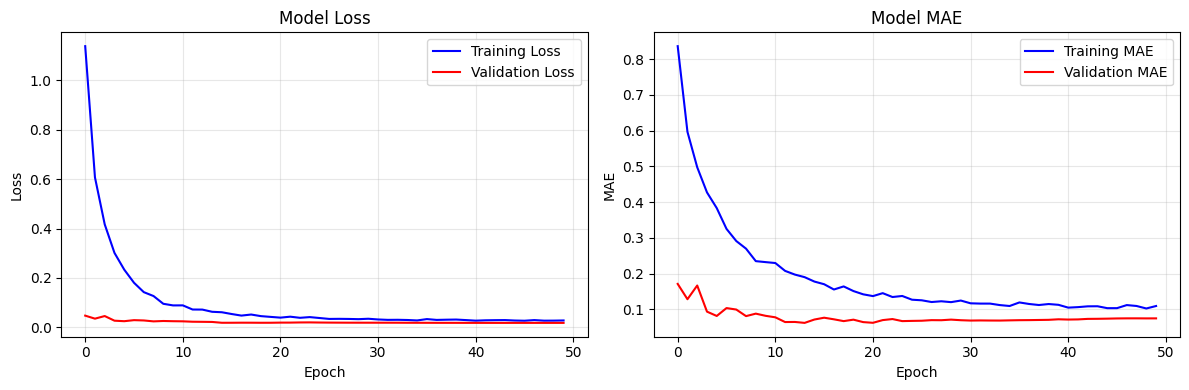

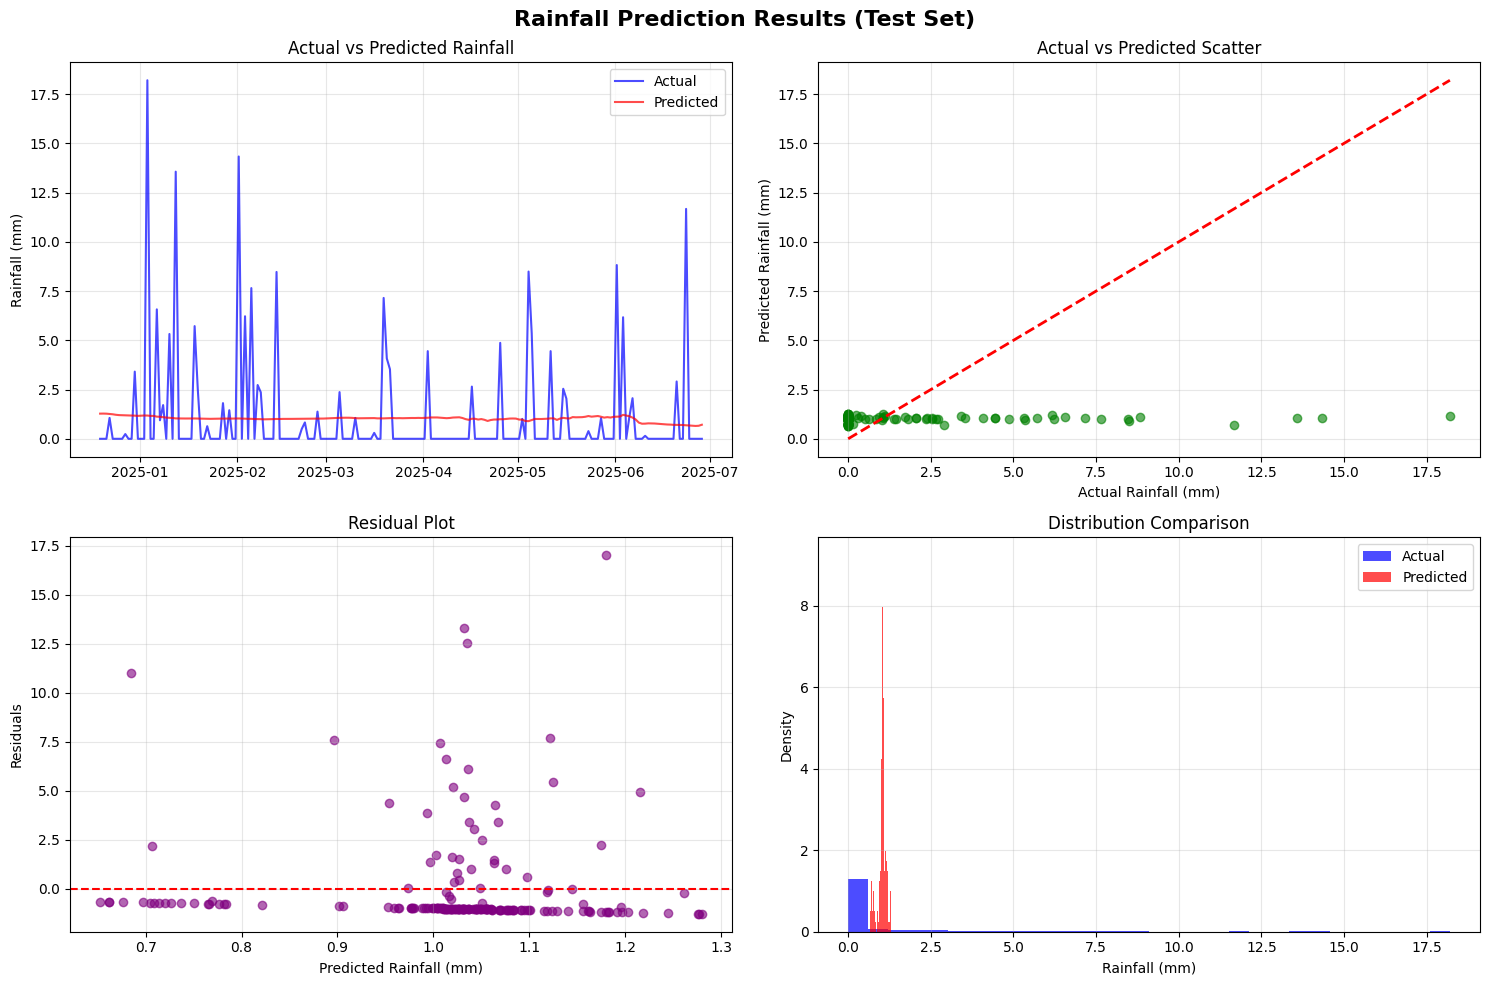


7️⃣  FEATURE ANALYSIS
🔍 Analyzing feature importance...
🎯 Top 10 features correlated with rainfall:
  2. heavy_rain: 0.8126
  3. rain_binary: 0.6645
  4. rainfall_roll_3: 0.5769
  5. rainfall_roll_7: 0.4011
  6. rainfall_roll_14: 0.2880
  7. cloud_cover: 0.1415
  8. humidity: 0.1228
  9. humidity_roll_3: 0.1127
  10. pressure_diff: 0.1124
  11. pressure: 0.1114


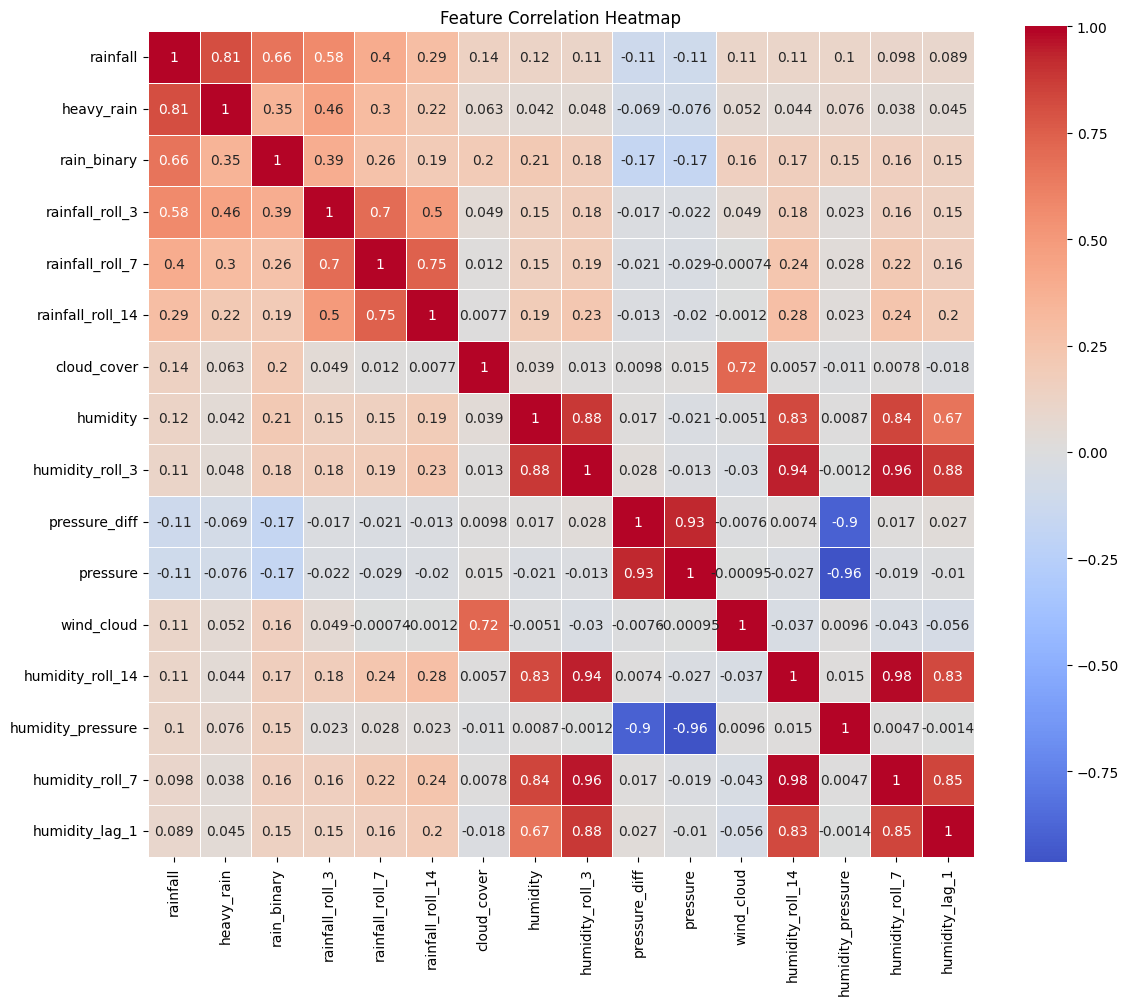


🎉 Pipeline completed successfully!
🔮 Predicting rainfall for next 7 days...
📊 Preparing sequences with length 30...
✅ Created 20 sequences
📏 Sequence shape: (20, 30, 43)
📅 Future Rainfall Predictions:
  2025-06-29: 0.37 mm - ☀️ No rain expected
  2025-06-30: 0.36 mm - ☀️ No rain expected
  2025-07-01: 0.35 mm - ☀️ No rain expected
  2025-07-02: 0.34 mm - ☀️ No rain expected
  2025-07-03: 0.33 mm - ☀️ No rain expected
  2025-07-04: 0.32 mm - ☀️ No rain expected
  2025-07-05: 0.31 mm - ☀️ No rain expected

📋 SUMMARY REPORT
✅ Model successfully trained and evaluated
📊 Test RMSE: 2.6748
📊 Test MAE: 1.5830
📊 Rain/No-Rain Accuracy: 0.2448
🔮 Future predictions generated for next 7 days
💾 Model saved as 'best_rainfall_model.h5'

🔧 System is ready for additional analysis!
Examples of what you can do:
- system.predict_future(days_ahead=14)  # Predict 14 days ahead
- system.analyze_features()  # Detailed feature analysis
- system.model.model.summary()  # View model architecture


In [21]:
def main():
    """Main function to run the complete system"""
    print("🌦️  Welcome to the Advanced Rainfall Prediction System!")
    print("🚀 This system uses LSTM neural networks to predict rainfall patterns")
    print("=" * 70)

    # Initialize and run the system
    system = RainfallPredictionSystem()

    # Run complete pipeline
    results = system.run_complete_pipeline(days=1000, sequence_length=30)

    # Make future predictions
    future_dates, future_predictions = system.predict_future(days_ahead=7)

    # Summary report
    print("\n📋 SUMMARY REPORT")
    print("=" * 50)
    print(f"✅ Model successfully trained and evaluated")
    print(f"📊 Test RMSE: {results['test_metrics']['RMSE']:.4f}")
    print(f"📊 Test MAE: {results['test_metrics']['MAE']:.4f}")
    print(f"📊 Rain/No-Rain Accuracy: {results['test_metrics']['Rain/No-Rain Accuracy']:.4f}")
    print(f"🔮 Future predictions generated for next 7 days")
    print(f"💾 Model saved as 'best_rainfall_model.h5'")

    return system, results

if __name__ == "__main__":
    # Run the main system
    system, results = main()

    # Additional analysis examples
    print("\n🔧 System is ready for additional analysis!")
    print("Examples of what you can do:")
    print("- system.predict_future(days_ahead=14)  # Predict 14 days ahead")
    print("- system.analyze_features()  # Detailed feature analysis")
    print("- system.model.model.summary()  # View model architecture")